In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics, model_selection

import time
#from matplotlib import pyplot as plt
from matplotlib import pylab as plt
from IPython import display

from Funciones import evaluar, evaluarDerivada

In [2]:
df = pd.read_csv('../Datos/iris.csv')
nomClases = pd.unique(df['class'])

df

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [3]:
# Tomamos todas las columnas menos la última
X = np.array(df.iloc[:, 0:-1])
Y = np.array(df.iloc[:,-1])

le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# creating instance of one-hot-encoder
#enc = preprocessing.OneHotEncoder(handle_unknown='ignore')# passing bridge-types-cat column (label encoded values of bridge_types)
#Y = enc.fit_transform(Y.reshape(-1,1)).toarray()


In [4]:
entradas = X.shape[1]
ocultas = 2

#-- la red tendrá una salida para cada tipo de flor
salidas = len(np.unique(Y))
print("entradas = %d ; salidas = %d" % (entradas, salidas))

entradas = 4 ; salidas = 3


In [5]:
#--- CONJUNTOS DE ENTRENAMIENTO Y TESTEO ---
X_train, X_test, Y_train, Y_test = model_selection.train_test_split( \
        X,Y, test_size=0.30)#, random_state=42)

normalizarEntrada = 1  # 1 si normaliza; 0 si no

if normalizarEntrada:
    # Escala los valores entre 0 y 1
    min_max_scaler = preprocessing.StandardScaler()
    X_train = min_max_scaler.fit_transform(X_train)
    X_test = min_max_scaler.transform(X_test)
    
Y_trainB = np.zeros((len(Y_train), salidas))
for o in range(len(Y_train)):
    Y_trainB[o, Y_train[o]]=1    

In [6]:
W1 = np.random.uniform(-0.5,0.5,[ocultas, entradas])
b1 = np.random.uniform(-0.5,0.5, [ocultas,1])
W2 = np.random.uniform(-0.5,0.5,[salidas, ocultas])
b2 = np.random.uniform(-0.5,0.5, [salidas,1])

In [7]:
FunH = 'sigmoid'
FunO = 'tanh'

if (FunO=='tanh'):
    Y_trainB = 2*Y_trainB -1
#    Y_testB  = 2*Y_testB - 1

In [8]:
nFilas = X_train.shape[0]

alfa = 0.1
CotaError = 1.0e-4
MAX_ITERA = 400
ite = 0
errorAnt = 0
AVGError = 1
errores = []
ph=0
while ( abs(AVGError-errorAnt) > CotaError ) and ( ite < MAX_ITERA ):
    errorAnt = AVGError
    AVGError = 0
    for e in range(nFilas):  #para cada ejemplo

        xi = X_train[e:e+1, :]     # ejemplo a ingresar a la red
        yi = Y_trainB[e:e+1, :]     # salida esperada para el ejemplo seleccionado
        
        # propagar el ejemplo hacia adelante
        netasH = W1 @ xi.T + b1
        salidasH = evaluar(FunH, netasH)
        netasO = W2 @ salidasH + b2
        salidasO = evaluar(FunO, netasO)

        # calcular los errores en ambas capas        
        ErrorSalida = yi.T-salidasO
        
        deltaO = ErrorSalida * evaluarDerivada(FunO,salidasO)
        deltaH = evaluarDerivada(FunH,salidasH)*(W2.T @ deltaO)

        # corregir todos los pesos      
        W1 = W1 + alfa * deltaH @ xi 
        b1 = b1 + alfa * deltaH 
        W2 = W2 + alfa * deltaO @ salidasH.T 
        b2 = b2 + alfa * deltaO 

        AVGError = AVGError + np.mean(ErrorSalida**2)
    
    AVGError = AVGError / nFilas
    errores.append(AVGError)
    
    ite = ite + 1

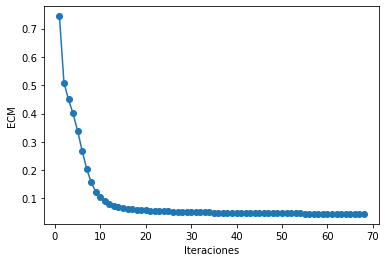

In [9]:
plt.plot(range(1, len(errores) + 1), errores, marker='o')
plt.xlabel('Iteraciones')
plt.ylabel('ECM')
plt.show()

In [30]:
# Respuesta de la red para los datos de ENTRENAMIENTO ---
NetasH = W1 @ X_train.T + b1
SalidasH = evaluar(FunH, NetasH)
NetasO = W2 @ SalidasH + b2
SalidasO = evaluar(FunO, NetasO)
SalidasO[:, :5]

array([[ 0.95977323,  0.95389794, -0.99886124,  0.96056708,  0.96076758],
       [-0.91855467, -0.90709279, -0.91539138, -0.92011014, -0.92050326],
       [-0.99986901, -0.99986004,  0.95776811, -0.99987027, -0.99987059]])

In [31]:
Y_pred = np.argmax(SalidasO,axis=0)
print("%% aciertos X_train : %.3f" % metrics.accuracy_score(Y_train,Y_pred))

% aciertos X_train : 0.990


In [32]:
report = metrics.classification_report(Y_train,Y_pred)
print("Confusion matrix Training:\n%s" % report) 

Confusion matrix Training:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      0.97      0.99        36
           2       0.97      1.00      0.99        39

    accuracy                           0.99       105
   macro avg       0.99      0.99      0.99       105
weighted avg       0.99      0.99      0.99       105



In [33]:
MM = metrics.confusion_matrix(Y_train,Y_pred)
print("Confusion matrix:\n%s" % MM)

Confusion matrix:
[[30  0  0]
 [ 0 35  1]
 [ 0  0 39]]


In [34]:
# -- TESTING ---
NetasH = W1 @ X_test.T + b1
SalidasH = evaluar(FunH, NetasH)
NetasO = W2 @ SalidasH + b2
SalidasO = evaluar(FunO, NetasO)

Y_pred = np.argmax(SalidasO,axis=0)
print("%% aciertos X_test : %.3f\n" % metrics.accuracy_score(Y_test,Y_pred))

report = metrics.classification_report(le.inverse_transform(Y_test),le.inverse_transform(Y_pred))
print("Confusion matrix Test:\n%s" % report) 

MM = metrics.confusion_matrix(Y_test, Y_pred)
print("Confusion matrix:\n%s" % MM)

% aciertos X_test : 0.978

Confusion matrix Test:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        20
Iris-versicolor       0.93      1.00      0.97        14
 Iris-virginica       1.00      0.91      0.95        11

       accuracy                           0.98        45
      macro avg       0.98      0.97      0.97        45
   weighted avg       0.98      0.98      0.98        45

Confusion matrix:
[[20  0  0]
 [ 0 14  0]
 [ 0  1 10]]
